# Initial code
* This notebook can be useful if you are not familiar to build training, validation, and testing pipelines.
* To provide hands-on experience, we are using lightning to help go over the entire training and evaluation processes.

Good luck!

## Import All Libraries

In [1]:
import os
import json
import random
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import F1Score
from torchvision import transforms
import torchvision.models as models

# Lightning
# import lightning as L
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import Tuner

### Initial data transformation steps

In [2]:
# Define transformations for the train, validation, and test sets
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Define a global variable for building labels

In [3]:
building_labels = {}
with open('/kaggle/input/csu-building-classification/csu_buildings/building_labels.json', 'r') as f:
    building_labels = json.load(f)

print(building_labels)

{'0': 'Admin', '1': 'Ammons', '2': 'Anatomy_Zoology_Yates_Chemistry', '3': 'Animal_Science', '4': 'Behavioral_Sciences', '5': 'Biology', '6': 'Chemistry_Research', '7': 'Clark', '8': 'Computer_Science', '9': 'Danforth_Chapel', '10': 'Eddy', '11': 'Education', '12': 'Engineering', '13': 'Environmental_Health', '14': 'Forestry', '15': 'Gibbons', '16': 'Glover', '17': 'Guggenheim', '18': 'Industrial_Science_Lab', '19': 'Insectary', '20': 'Johnson_Centennial_Student_Services', '21': 'Laurel', '22': 'Lory_Student_Center', '23': 'Microbiology', '24': 'Military_Annex', '25': 'Military_Sciences', '26': 'Moby_Arena', '27': 'Morgan_Library', '28': 'NESB', '29': 'NRRL', '30': 'OT', '31': 'OT_Annex', '32': 'Painter', '33': 'Pathology', '34': 'Physiology', '35': 'Plant_Growth_Facilities', '36': 'Plant_Science', '37': 'Preconstruction_Center', '38': 'Rockwell', '39': 'Scott_Bioengineering', '40': 'Shepardson', '41': 'Smith_Natural_Resources', '42': 'Stadium', '43': 'Statistics', '44': 'Student_Recre

## CSUBuildingDataset: Custom dataset class

In [4]:
class CSUBuildingDataset(Dataset):
    def __init__(self, csv_file, root_dir, mode, transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.data = []
        self.labels = []

        # Load the json file
        with open(root_dir+'/'+csv_file, 'r') as f:
            print(f"Loading data from {root_dir+'/'+csv_file}")
            building_data = pd.read_csv(f)
            building_imgs = building_data['ImageID']
            building_labels = building_data['Label']
        
        # Building names and their corresponding labels
        with open(root_dir+'/'+'building_labels.json', 'r') as f:
            self.building_names = json.load(f)
            
        # Prepare the data and labels
        for img, label in zip(building_imgs, building_labels):
            if pd.isna(label) and mode == 'test':
                continue
            if pd.isna(label) and 'hidden' in mode:
                self.labels.append(int(0))
                self.data.append(f'{self.root_dir}/frames/{img:08d}.png')
                continue
            self.labels.append(int(label))
            self.data.append(f'{self.root_dir}/frames/{img:08d}.png')
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

            
        return image, label, self.data[idx].split('.')[0].split('/')[-1]

#### Check the input data

In [5]:


!ls /kaggle/input/csu-building-classification/csu_buildings

building_labels.json  sample_submission.csv  train.csv
frames		      test.csv		     val.csv


* NOTE: All files are under `/kaggle/input/csu-building-classification/csu_buildings`

In [6]:
root_path = '/kaggle/input/csu-building-classification/csu_buildings'
val_data = 'val.csv'
mode = 'val'
sampleDataset = CSUBuildingDataset(val_data, root_path, mode, None)

Loading data from /kaggle/input/csu-building-classification/csu_buildings/val.csv


Size of sampleDataset: 532


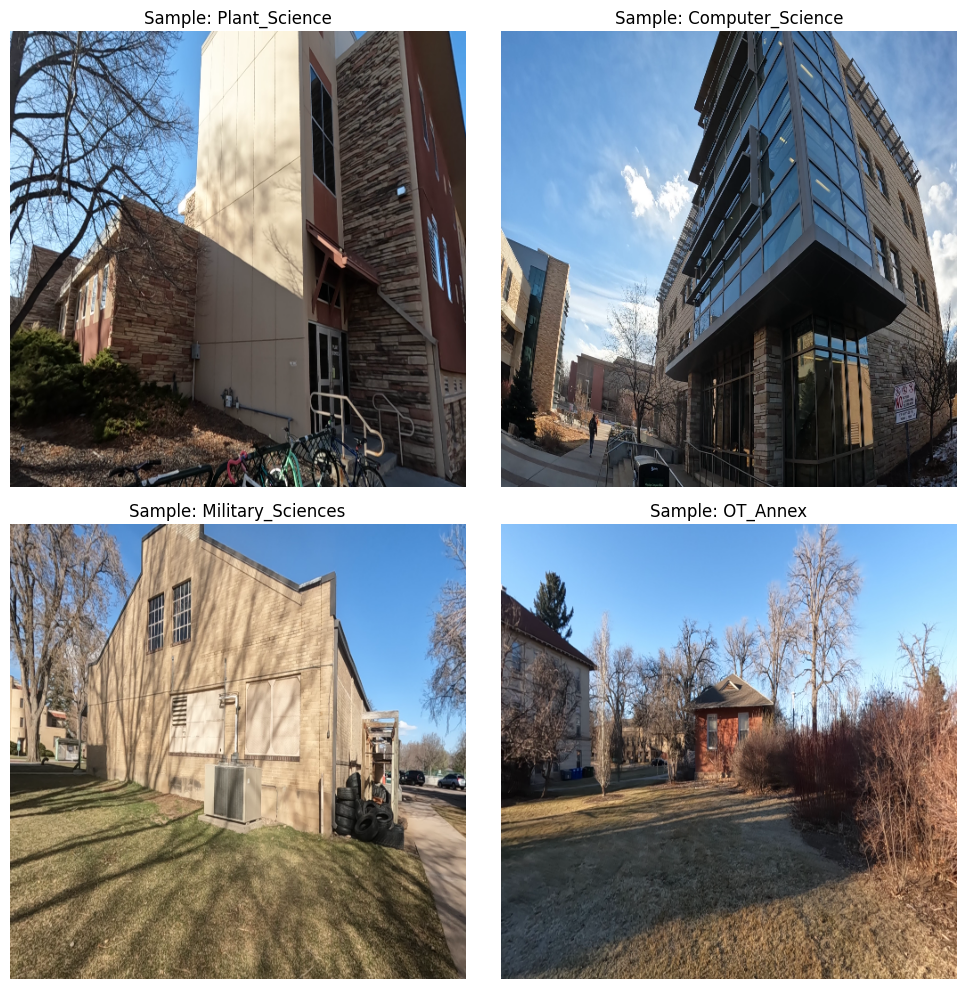

In [7]:
n = len(sampleDataset)
print(f'Size of sampleDataset: {n}')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    rand_idx = random.randint(0, n - 1)
    img, label, _ = sampleDataset[rand_idx]
    img = img * 255.0

    if img.shape[0] == 3:
        img_np = img.permute(1, 2, 0).numpy()
    
    ax = axs[i // 2, i % 2]
    ax.imshow(img_np.astype('uint8'))
    ax.set_title(f'Sample: {building_labels[str(label)]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## BuildingClassifier

In [8]:
class BuildingClassifier(pl.LightningModule):
    def __init__(self, num_classes=49, learning_rate=0.0001, mode='exp'):
        super(BuildingClassifier, self).__init__()
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.mode = mode
        self.model = self._get_model()
        self.criterion = torch.nn.CrossEntropyLoss()
        self.f1_score = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.save_hyperparameters()
        
        self.train_loss_list, self.val_loss_list, self.train_acc_list, self.val_acc_list = [], [], [], []        
        self.test_preds = {
            'ImageID' : [],
            'Label' : []
        }
    
    def _get_model(self):
        m = models.resnet18(weights=None) # NOTE: pretrained weights are not allowed in our competition.
        in_features = m.fc.in_features
        m.fc = torch.nn.Linear(in_features, self.num_classes)
        return m

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels, _ = batch
        labels = torch.tensor(labels)
        outputs = self(inputs)
        train_loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        train_acc = (predicted == labels).sum().item() / labels.size(0)
        training_log = {
            'train_loss': train_loss,
            'train_acc': train_acc,
        }
        self.train_loss_list.append(train_loss.item())
        self.train_acc_list.append(train_acc)
        self.log_dict(training_log, prog_bar=True)
        return train_loss

    def validation_step(self, batch, batch_idx):
        inputs, labels, _ = batch
        labels = torch.tensor(labels)
        outputs = self(inputs)
        val_loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        val_acc = (predicted == labels).sum().item() / labels.size(0)
        validation_log = {
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        self.val_loss_list.append(val_loss.item())
        self.val_acc_list.append(val_acc)
        self.log_dict(validation_log, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels, frame_names = batch
        labels = torch.tensor(labels)
        outputs = self(inputs)
        _, predicted = torch.max(outputs, 1)
        frame_indices = [int(i) for i in frame_names]
        self.test_preds['ImageID'] += frame_indices
        self.test_preds['Label'].append(predicted.item())
        if self.mode != 'test_hidden':
            test_loss = self.criterion(outputs, labels)
            test_acc = (predicted == labels).sum() / labels.size(0)
            test_f1 = self.f1_score(predicted, labels)
            test_log = {
                'test_loss': test_loss,
                'test_acc': test_acc,
                'test_f1': test_f1
            }
            self.log_dict(test_log, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

#### Check the model with a random tensor

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
rgb = torch.randn(32, 3, 256, 256).to(device)
model = BuildingClassifier(49, 0.0001).to(device)

# Get number of parameters in M
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params/1e6:.2f}M")

cls_preds = model(rgb)

print(cls_preds.shape)

cuda:0
Number of parameters: 11.20M
torch.Size([32, 49])


In [10]:
# model.model.layer1[0].relu = nn.Tanh()
model.model.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Training and Validation

In [11]:
from collections import defaultdict 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CSUBuildingDataset(csv_file='train.csv', root_dir='/kaggle/input/csu-building-classification/csu_buildings', mode='train', transform=transform)
val_dataset = CSUBuildingDataset(csv_file='val.csv', root_dir='/kaggle/input/csu-building-classification/csu_buildings', mode='val', transform=transform)

# Print number of images per building in both train and validation datasets
# train_labels = [label for _, label, _ in train_dataset]
# val_labels = [label for _, label, _ in val_dataset]

# train_labels = [building_labels[str(label)] for label in train_labels]
# val_labels = [building_labels[str(label)] for label in val_labels]

# print("Train dataset:")
# print(pd.Series(train_labels).value_counts())
# print("\nValidation dataset:")
# print(pd.Series(val_labels).value_counts())
    
# Drop entries in the validation set if in the training set as well

train_samples = [sample.split('/')[-1] for sample in train_dataset.data]
val_samples = [sample.split('/')[-1] for sample in val_dataset.data]
common_samples = set(train_samples).intersection(set(val_samples))

val_dataset.data = [sample for sample in val_dataset.data if sample.split('/')[-1] not in common_samples]

batch_size = 8
n_workers = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

model = BuildingClassifier(num_classes=49, learning_rate=0.00005)


checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working',
    filename=f'BC-{{epoch:04d}}-{{val_loss:.6f}}',
    save_top_k=1,
    mode='min'
)

# early_stopping = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=10, verbose=False, mode="max")

trainer = Trainer(
    max_epochs=28,
    precision="bf16-mixed",
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback],
)

Loading data from /kaggle/input/csu-building-classification/csu_buildings/train.csv
Loading data from /kaggle/input/csu-building-classification/csu_buildings/val.csv


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Run training / validation

In [12]:
trainer.fit(model, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_23/1881218889.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_23/1881218889.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

#### Check the training and validation

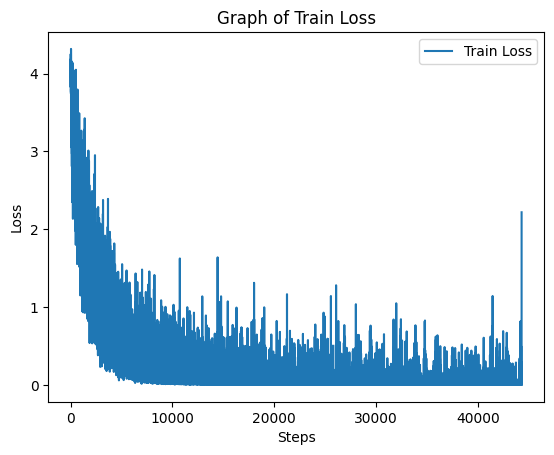

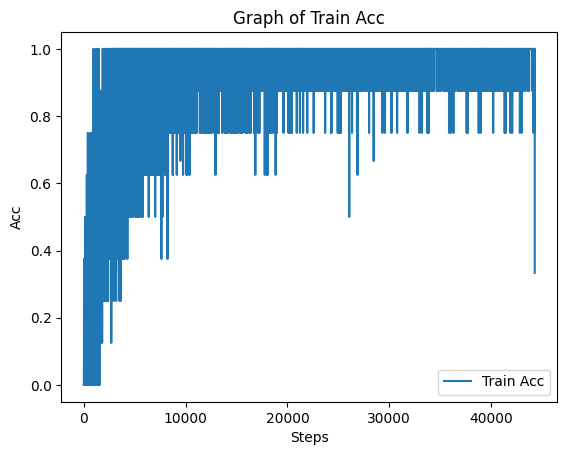

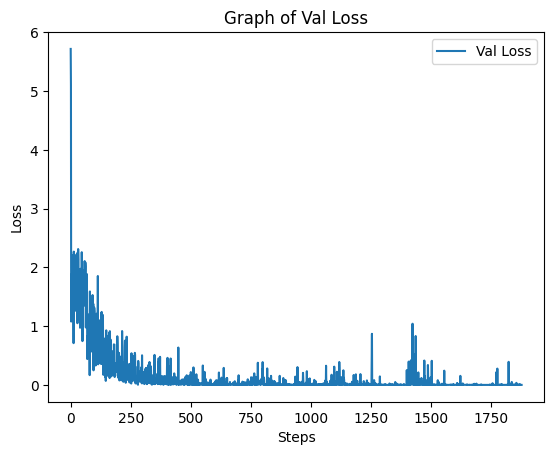

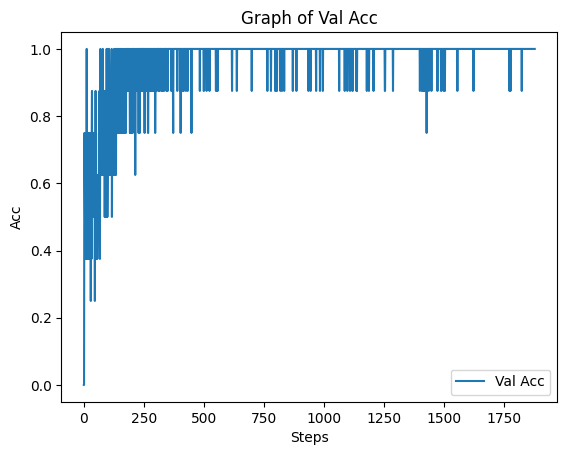

In [13]:
train_losses, val_losses = model.train_loss_list, model.val_loss_list
train_accs, val_accs = model.train_acc_list, model.val_acc_list
steps = range(len(train_losses))
plt.figure()
plt.title('Graph of Train Loss')
plt.plot(steps, train_losses, label='Train Loss')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Graph of Train Acc')
plt.plot(steps, train_accs, label='Train Acc')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Acc')
plt.show()

steps = range(len(val_losses))
plt.figure()
plt.title('Graph of Val Loss')
plt.plot(steps, val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.title('Graph of Val Acc')
plt.plot(steps, val_accs, label='Val Acc')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Acc')
plt.show()

## Run Testing without hidden

In [14]:
batch_size = 1
n_workers = 16
test_dataset = CSUBuildingDataset(csv_file='test.csv', root_dir='/kaggle/input/csu-building-classification/csu_buildings', mode='test', transform=transform)
print(f'size of test set without hidden set: {len(test_dataset)}')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

trained_models = glob.glob('/kaggle/working/*.ckpt')
best_model = None
min_val = 1e6
for m in trained_models:
    ckpt_name = m.rsplit('.', 1)[0]
    val_loss = float(ckpt_name.split('/')[-1].split('-val_loss=')[-1])
    if val_loss < min_val:
        min_val = val_loss
        best_model = m
print(f'The best model is {best_model}')

# Load models
model = BuildingClassifier.load_from_checkpoint(
    checkpoint_path=best_model,
    num_classes=49
).cuda()
trainer = Trainer(
    max_epochs=1,
    precision="bf16",
    accelerator="gpu",
    devices=1,
)
trainer.test(model, test_loader)

Loading data from /kaggle/input/csu-building-classification/csu_buildings/test.csv
size of test set without hidden set: 1493
The best model is /kaggle/working/BC-epoch=0025-val_loss=0.001248.ckpt


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/lightning_fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_23/1881218889.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.33154723048210144    │
│          test_f1          │    0.33154723048210144    │
│         test_loss         │     4.40960168838501      │
└───────────────────────────┴───────────────────────────┘

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'test_loss': 4.40960168838501,
  'test_acc': 0.33154723048210144,
  'test_f1': 0.33154723048210144}]

## Test with hidden data for submission

In [15]:
batch_size = 1
n_workers = 16
test_dataset = CSUBuildingDataset(csv_file='test.csv', root_dir='/kaggle/input/csu-building-classification/csu_buildings', mode='test_hidden', transform=transform)
print(f'size of test set with hidden set: {len(test_dataset)}')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

trained_models = glob.glob('/kaggle/working/*.ckpt')
best_model = None
min_val = 1e6
for m in trained_models:
    ckpt_name = m.rsplit('.', 1)[0]
    val_loss = float(ckpt_name.split('/')[-1].split('-val_loss=')[-1])
    if val_loss < min_val:
        min_val = val_loss
        best_model = m
print(f'The best model is {best_model}')

# Load models
model = BuildingClassifier.load_from_checkpoint(
    checkpoint_path=best_model,
    num_classes=49,
    mode='test_hidden'
).cuda()
trainer = Trainer(
    max_epochs=1,
    precision="bf16",
    accelerator="gpu",
    devices=1
)
trainer.test(model, test_loader)

Loading data from /kaggle/input/csu-building-classification/csu_buildings/test.csv
size of test set with hidden set: 2986
The best model is /kaggle/working/BC-epoch=0025-val_loss=0.001248.ckpt


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/lightning_fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_23/1881218889.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{}]

## Save the predictions

In [16]:
test_data = model.test_preds
output = pd.DataFrame(test_data)

In [17]:
output.head(10)

,ImageID,Label
0,0,5
1,8,47
2,13,32
3,17,0
4,22,5
5,24,44
6,28,8
7,30,38
8,39,32
9,44,43


In [18]:
output.to_csv('submission.csv', index=False, sep=',')